# Trabajo Práctico N° 2 IA: Sistemas inteligentes


## 1. Importar librerias y cargar imagenes a utilizar


In [1]:
use_drive = True

In [3]:
import os
import re
import xml.etree.ElementTree as ET

import numpy as np
import seaborn as sns
import tensorflow as tf
if use_drive: from google.colab import drive
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical

In [4]:
if use_drive:
    drive.mount('/content/gdrive', force_remount=True)
    base_path = 'gdrive/MyDrive/IA-TP'
else:
    base_path =  os.getcwd()
training_path = base_path + '/images/Train'
test_path = base_path + '/images/Test'
cropped_training_path = base_path + '/cropped_images/Training'
cropped_test_path = base_path + '/cropped_images/Test'

## 2. Análisis de los datos a utilizar

En las carpetas **train** y **test** se encuentran imágenes de 770 x 600 de distintos jeroglíficos egipcios. Existen varias imagenes para un mismo jeroglífico, cada una de ellas con pequeñas variaciones en cuanto al ángulo o la posición. A continuación se muestran dos ejemplos:

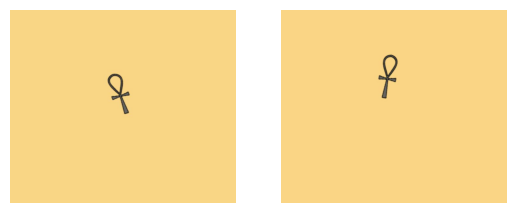

In [5]:
example_image_1 = Image.open(test_path + '/ankh (43).jpg')
example_image_2 = Image.open(test_path + '/ankh (47).jpg')

fig, axes = plt.subplots(1, 2)
axes[0].imshow(example_image_1)
axes[0].axis('off')
axes[1].imshow(example_image_2)
axes[1].axis('off')

plt.show()

El atributo objetivo (categoría del jeroglífico) se encuentra en un archivo XML que acompaña a cada imagen.
A su vez, este archivo incluye cuatro coordenadas que definen un Bounding Box (cuadro delimitador, en español), delimitando el área exacta de la imagen donde se encuentra el jeroglífico. Esto será muy util al preparar las imágenes, ya que como se ve en los ejemplos anteriores la mayor parte correspende al fondo, el cual no aporta información relevante para la clasificación.

# 3. Preparación de los datos
La preparación de los datos consistirá de los siguientes pasos:

1.   Recortar las imagenes de acuerdo al Bounding Box, como se explico en la sección anterior
2.   Redimensionar las imagenes, para que todas tengan el mismo tamaño, en este caso de 128 x 128 px
3.   Convertir las imagenes a una escala de grises, ya que los colores no son relevantes para la clasificación
4.   Transformar las imagenes en un vector y reescalar los valores en una escala entre 0 y 1
5.   Transformar el atributo objetivo de un "String" a un vector, utilizando el método de one-hot encoding
6.   Eliminar las siguientes categorías: "Head" ya que solo hay imagenes de la misma en los datos de prueba y 'Limits', 'Nile fish' y 'Foots', ya que las imágenes de estas 3 categorías son las mismas que las de otras 3, pero con otra etiqueta, lo que generaba problemas al entrenar el modelo. Decidimos eliminarlos y no cambiar su etiqueta ya que como se observará en las siguientes secciones cada categoría tiene aproximadamente la misma cantidad de ejemplos, por lo que se duplicaría la cantidad de ejemplos de solo de esas 3 categorías, desbalanceando los datos disponibles.


>Las funciones que están en la siguiente celda son para recortar las imagenes y generar un set de datos solo con imágenes, como lo pide la consigna. Si ya se tienen estos datos NO HACE FALTA ejecutarlas de vuelta, se puede trabajar con los datos ya generados. Ejecutarlas puede tardar bastatne tiempo, sobre todo en colab con Google Drive


In [ ]:
def crop_image(image_path, xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    xmin = int(root.find('.//bndbox/xmin').text)
    ymin = int(root.find('.//bndbox/ymin').text)
    xmax = int(root.find('.//bndbox/xmax').text)
    ymax = int(root.find('.//bndbox/ymax').text)
    
    image = Image.open(image_path)
    cropped_image = image.crop((xmin, ymin, xmax, ymax))
    return cropped_image
    
def crop_images_and_save(source, dest, quiet=True):
    if not os.path.exists(dest):
        os.makedirs(dest)  # Crea el directorio si no existe
    skip = {'head.jpg', 'limits.jpg', 'nile fish.jpg', 'foot.jpg'}
    for i, file in enumerate(os.listdir(source)):
        if not quiet:
            print(f"Procesando {file} ({i+1}/{len(os.listdir(source))})")
        if file.endswith('.jpg') and re.sub(r'\s*\(\d+\)', '', file).strip() not in skip:
            image_path = os.path.join(source, file)
            xml_path = image_path.replace('.jpg', '.xml')
            if os.path.exists(xml_path):
                image = crop_image(image_path, xml_path)
                image.save(os.path.join(dest, file))
            elif not quiet:
                print(f"Saltando {file} ya que no se encontró el archivo XML correspondiente")
                
# Esto puede llevar bastante tiempo, sobre todo en colab si se lee de drive
crop_images_and_save(training_path, cropped_training_path)
crop_images_and_save(test_path, cropped_test_path)

In [6]:
def process_image(image_path):
    image = Image.open(image_path)
    resized_image = image.resize((128, 128))
    grayscale_image = resized_image.convert('L')
    rescaled_image = np.array(grayscale_image) / 255.0
    return rescaled_image

def process_images(dir_path, quiet=True):
    images = []
    categories = []
    for i, file in enumerate(os.listdir(dir_path)):
        if not quiet:
            print(f"Procesando {file} ({i+1}/{len(os.listdir(dir_path))})")
        image_path = os.path.join(dir_path, file)
        images.append(process_image(image_path))
        category = re.sub(r'\s*\(\d+\)', '', file).strip().capitalize()
        categories.append(category)
    return np.array(images), np.array(categories)

def get_one_hot_encoding(categories, category_to_int_map):
    vec = [category_to_int_map[category] for category in categories]
    return to_categorical(vec)

In [7]:
# Esto puede llevar un tiempo, sobre todo en colab si se lee de drive
processed_training_images, processed_training_categories = process_images(cropped_training_path)
processed_test_images, processed_test_categories= process_images(cropped_test_path)

In [8]:
category_to_int_map = {category: index for index, category in enumerate(np.unique(processed_training_categories))}
encoded_training_categories = get_one_hot_encoding(processed_training_categories, category_to_int_map)
encoded_test_categories = get_one_hot_encoding(processed_test_categories, category_to_int_map)

## 4. Distribución de los datos

El set de datos utilizado ya contaba con la división entre datos de prueba y datos de entrenamiento, a continuación se muestra la información principal de cada uno.

In [9]:
training_quantity = len(processed_training_images)
test_quantity = len(processed_test_images)

print(f"Cantidad de datos totales: {training_quantity + test_quantity}")
print(f"Cantidad de datos de entrenamiento: {training_quantity}")
print(f"Porcentaje de datos de entrenamiento: {training_quantity / (training_quantity + test_quantity):.2%}")
print(f"Cantidad de datos de prueba: {test_quantity}")
print(f"Porcentaje de datos de prueba: {test_quantity / (training_quantity + test_quantity):.2%}")


training_category_counts = dict(zip(*np.unique(processed_training_categories, return_counts=True)))
test_category_counts = dict(zip(*np.unique(processed_test_categories, return_counts=True)))
category_count = len(training_category_counts.keys())
print(f"\nCantidad de categorías: {category_count}")
print(f"Cantidad de ejemplos por categoría en datos de entrenamiento: {training_category_counts}")
print(f"Cantidad de ejemplos por categoría en datos de prueba: {test_category_counts}")

Cantidad de datos totales: 4772
Cantidad de datos de entrenamiento: 3766
Porcentaje de datos de entrenamiento: 78.92%
Cantidad de datos de prueba: 1006
Porcentaje de datos de prueba: 21.08%

Cantidad de categorías: 92
Cantidad de ejemplos por categoría en datos de entrenamiento: {'100.jpg': 41, 'Among.jpg': 41, 'Angry.jpg': 41, 'Ankh.jpg': 41, 'Aroura.jpg': 41, 'At.jpg': 41, 'Bad thinking.jpg': 41, 'Bandage.jpg': 41, 'Bee.jpg': 41, 'Belongs.jpg': 41, 'Birth.jpg': 41, 'Board game.jpg': 41, 'Book.jpg': 41, 'Boy.jpg': 40, 'Branch.jpg': 41, 'Bread.jpg': 41, 'Brewer.jpg': 41, 'Builder.jpg': 41, 'Bury.jpg': 41, 'Canal.jpg': 41, 'Cloth on pole.jpg': 41, 'Cobra.jpg': 41, 'Composite_bow.jpg': 41, 'Cooked.jpg': 41, 'Corpse.jpg': 41, 'Dessert.jpg': 41, 'Divide.jpg': 41, 'Duck.jpg': 41, 'Elephant.jpg': 41, 'Enclosed mound.jpg': 41, 'Eye.jpg': 41, 'Fabric.jpg': 41, 'Face.jpg': 41, 'Falcon.jpg': 41, 'Fingre.jpg': 41, 'Fish.jpg': 41, 'Flail.jpg': 41, 'Folded.jpg': 41, 'Galena.jpg': 41, 'Giraffe.jpg':

Según lo pedido en el trabajo, el set de prueba debe contener al menos el 25% de los ejemplo totales. Para resolver este problema decidimos tomar 2 ejemplos al azar de cada categoría y moverlos a los datos de prueba. Esto nos permite obtener 184 nuevos ejemplos de prueba y no debería afectar en gran medida al entrenamiento

In [10]:
for category in range(category_count):
    indices_category = np.where(encoded_training_categories[:, category] == 1)[0]
    selected_indices = np.random.choice(indices_category, size=2, replace=False)

    processed_test_images = np.vstack((processed_test_images, processed_training_images[selected_indices]))
    encoded_test_categories = np.vstack((encoded_test_categories, encoded_training_categories[selected_indices]))

    processed_training_images = np.delete(processed_training_images, selected_indices, axis=0)
    encoded_training_categories = np.delete(encoded_training_categories, selected_indices, axis=0)


Una vez realizado esto el porcentaje aumenta hasta un 24.94%

In [11]:
training_quantity = len(processed_training_images)
test_quantity = len(processed_test_images)

print(f"Cantidad de datos totales: {training_quantity + test_quantity}")
print(f"Cantidad de datos de entrenamiento: {training_quantity}")
print(f"Porcentaje de datos de entrenamiento: {training_quantity / (training_quantity + test_quantity):.2%}")
print(f"Cantidad de datos de prueba: {test_quantity}")
print(f"Porcentaje de datos de prueba: {test_quantity / (training_quantity + test_quantity):.2%}")

Cantidad de datos totales: 4772
Cantidad de datos de entrenamiento: 3582
Porcentaje de datos de entrenamiento: 75.06%
Cantidad de datos de prueba: 1190
Porcentaje de datos de prueba: 24.94%


El último paso a realizar en cuanto a la distribución de los datos es crear un set de validación. Para esto utilizaremos la funcion train_test_split de la libreria scikit-learn, separando un 10% de los datos de entrenamiento disponibles.

In [12]:
x_train, x_validation, y_train, y_validation = train_test_split(processed_training_images,
                                                              encoded_training_categories,
                                                              test_size=0.1, shuffle=True)

#Esto lo hago para mantener la convencion de nombres
x_test, y_test = processed_test_images, encoded_test_categories


Cantidad de datos totales: 4772
Cantidad de datos de entrenamiento: 3223
Cantidad de datos de validación: 359
Cantidad de datos de prueba: 1190


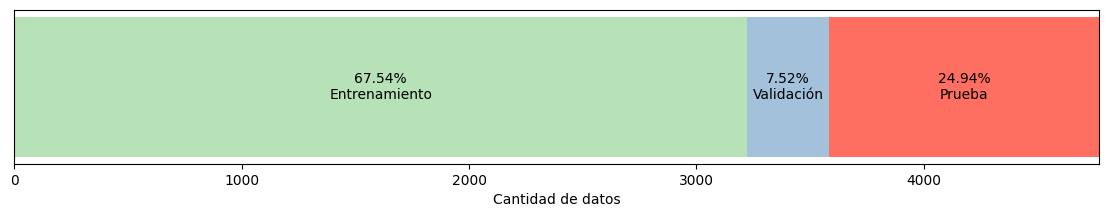

In [13]:
data = [len(x_train), len(x_validation), len(x_test)]
labels = ['Entrenamiento', 'Validación', 'Prueba']
total = sum(data)

print(f"Cantidad de datos totales: {total}")
print(f"Cantidad de datos de entrenamiento: {data[0]}")
print(f"Cantidad de datos de validación: {data[1]}")
print(f"Cantidad de datos de prueba: {data[2]}")

colors = ["#B7E1B7", "#A3C1DA", "#FF6F61"]

plt.figure(figsize=(14, 2))
plt.xlabel("Cantidad de datos")
plt.xlim(0,total)

plt.barh([0], data[0], color=colors[0])
plt.barh([0], data[1], left=data[0], color=colors[1])
plt.barh([0], data[2], left=data[0] + data[1], color=colors[2])

plt.yticks([])

aux = 0
for label, value in zip(labels, data):
    percentage = value / total
    text = f"{percentage:.2%}\n{label}"
    plt.text(aux + value/2, 0, text, va="center", ha="center")
    aux += value

plt.show()


## 5. Definición de la Red y Entrenamiento


In [14]:
def plot_training_history(history, figsize):
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Gráfico del Error del Entrenamiento')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    plt.show()

    plt.figure(figsize=figsize)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Gráfico de la Exactitud del Entrenamiento')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    plt.show()

def show_model_performance(x, y, model, data_type, existing_categories,figsize=(20,20)):
    prediction = model.predict(x, verbose=0)
    predicted_categories = []
    real_categories = []
    for i in range(len(x)):
        real_category = existing_categories[np.argmax(y[i])]
        predicted_category = existing_categories[np.argmax(prediction[i], axis=0)]
       
        predicted_categories.append(predicted_category)
        real_categories.append(real_category)

    print("\n Reporte de Clasificación: ")
    print(classification_report(real_categories, predicted_categories, zero_division=0))

    cm = confusion_matrix(real_categories, predicted_categories, labels=existing_categories)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicción')
    plt.ylabel('True Label')
    plt.title(f'Matriz de confusión para {model.name} con datos de {data_type}')
    plt.xticks(np.arange(len(existing_categories)) + 0.5, existing_categories, rotation=90)
    plt.yticks(np.arange(len(existing_categories)) + 0.5, existing_categories)
    plt.show()

def save_model(model):
    tf.keras.models.save_model(model, f'{base_path}/modelos_entrenados/{model.name}.keras')

### 5.1 RNA Multi-Perceptrón Backpropagation

### 5.3 Red Neuronal Convolucional (CNN)

#### 5.3.1 Primer intento
Se define una cnn con 10 capas la de entrada, una serie de capas de convolución y MaxPooling, una capa Flatten para "aplanar" los datos a un vector unidimensional, y finalmente dos capas densas o totalmente conectadas. Para todas las capas se utiliza la función de activacion RELU, excepto para la última donde se utiliza una softmax para obtener las probabilidades de cada categoría

Se utilizará el optimizador adam, con su valor de Learning Rate por defecto (0.001). Para la perdida se utiliza "categorical_crossentropy". El número de epocas a utilizar es de 100, pero se añadó un Callback de Early Stopping al modelo, con una paciencia de 10 épocas, que detiene el entrenamiento si no hay mejoras. El batch size a utilizar también es el valor por defecto definido por keras (32)

In [21]:
cnn_1_inputs = tf.keras.Input(shape=(128, 128, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(cnn_1_inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
cnn_1_outputs = tf.keras.layers.Dense(category_count, activation="softmax")(x)

cnn_1 = Model(inputs=cnn_1_inputs, outputs=cnn_1_outputs, name = "CNN_1")

In [22]:
cnn_early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [23]:
cnn_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
cnn_1.summary()

Model: "CNN_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 92)             │        11,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,315,932 (12.65 MB)

 Trainable params: 3,315,932 (12.65 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
cnn_1_history = cnn_1.fit(x_train, y_train, epochs=100,
                    validation_data=(x_validation, y_validation),
                    callbacks=[cnn_early_stopping])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 377ms/step - accuracy: 0.0245 - loss: 4.4582 - val_accuracy: 0.3008 - val_loss: 2.9992
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 383ms/step - accuracy: 0.4554 - loss: 2.1814 - val_accuracy: 0.6685 - val_loss: 1.2525
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 385ms/step - accuracy: 0.8174 - loss: 0.6087 - val_accuracy: 0.7577 - val_loss: 1.0013
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.9425 - loss: 0.2060 - val_accuracy: 0.7994 - val_loss: 0.9057
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - accuracy: 0.9796 - loss: 0.0781 - val_accuracy: 0.8440 - val_loss: 0.8585
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 39s 387ms/step - accuracy: 0.9887 - loss: 0.0536 - val_accuracy: 0.7911 - val_loss: 1.0536
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 377ms/step - accuracy: 0.9842 - loss: 0.0499 - val_accuracy: 0.8412 - val_loss: 0.9510
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 374ms/step - accuracy: 0.9806 -

In [26]:
save_model(cnn_1)
cnn_1.evaluate(x_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.8605 - loss: 0.6033


[0.6013842225074768, 0.8689075708389282]

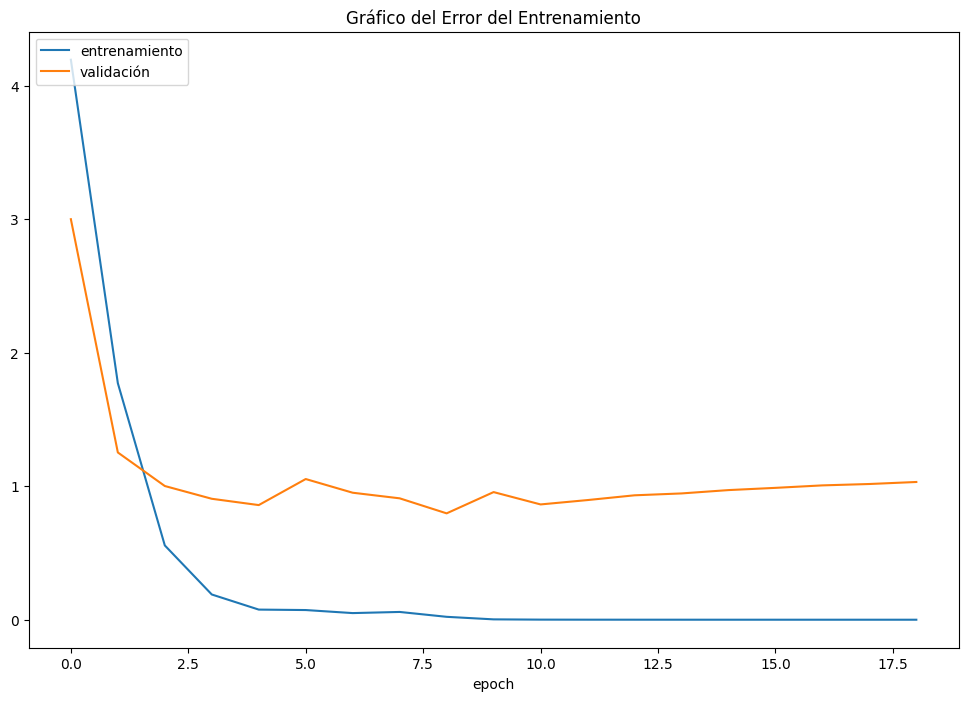

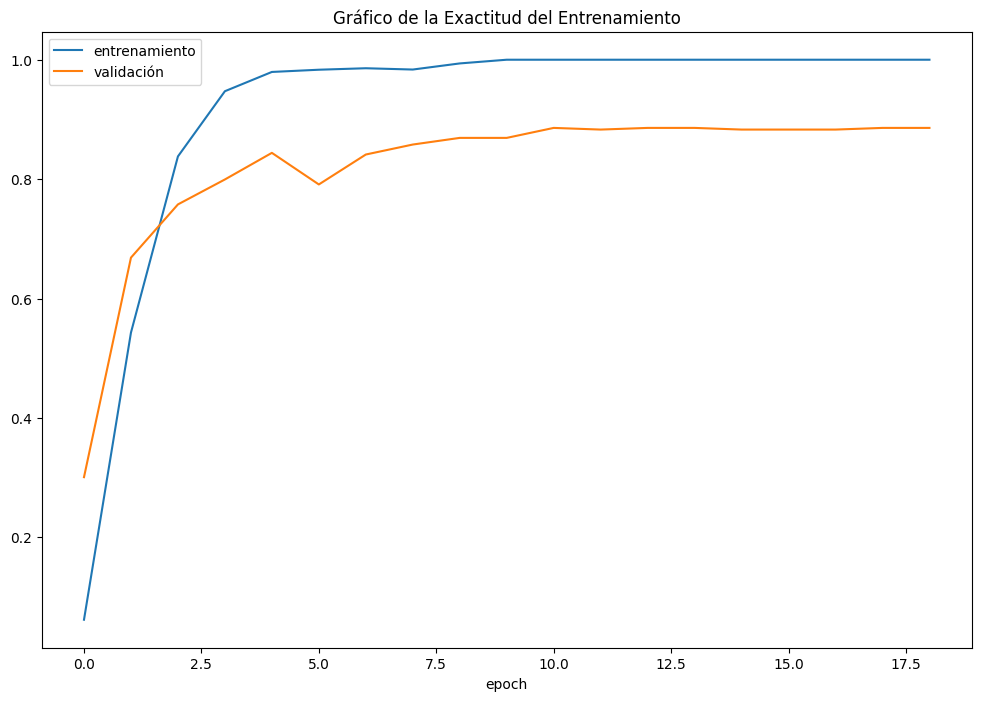

In [27]:
plot_training_history(cnn_1_history, (12,8))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       1.00      1.00      1.00        35
                Among.jpg       1.00      1.00      1.00        33
                Angry.jpg       1.00      1.00      1.00        38
                 Ankh.jpg       0.97      1.00      0.99        38
               Aroura.jpg       1.00      1.00      1.00        37
                   At.jpg       1.00      1.00      1.00        36
         Bad thinking.jpg       1.00      1.00      1.00        37
              Bandage.jpg       1.00      1.00      1.00        38
                  Bee.jpg       1.00      1.00      1.00        36
              Belongs.jpg       1.00      1.00      1.00        36
                Birth.jpg       1.00      0.97      0.99        34
           Board game.jpg       1.00      1.00      1.00        36
                 Book.jpg       1.00      1.00      1.00        38
                  Boy.jpg       

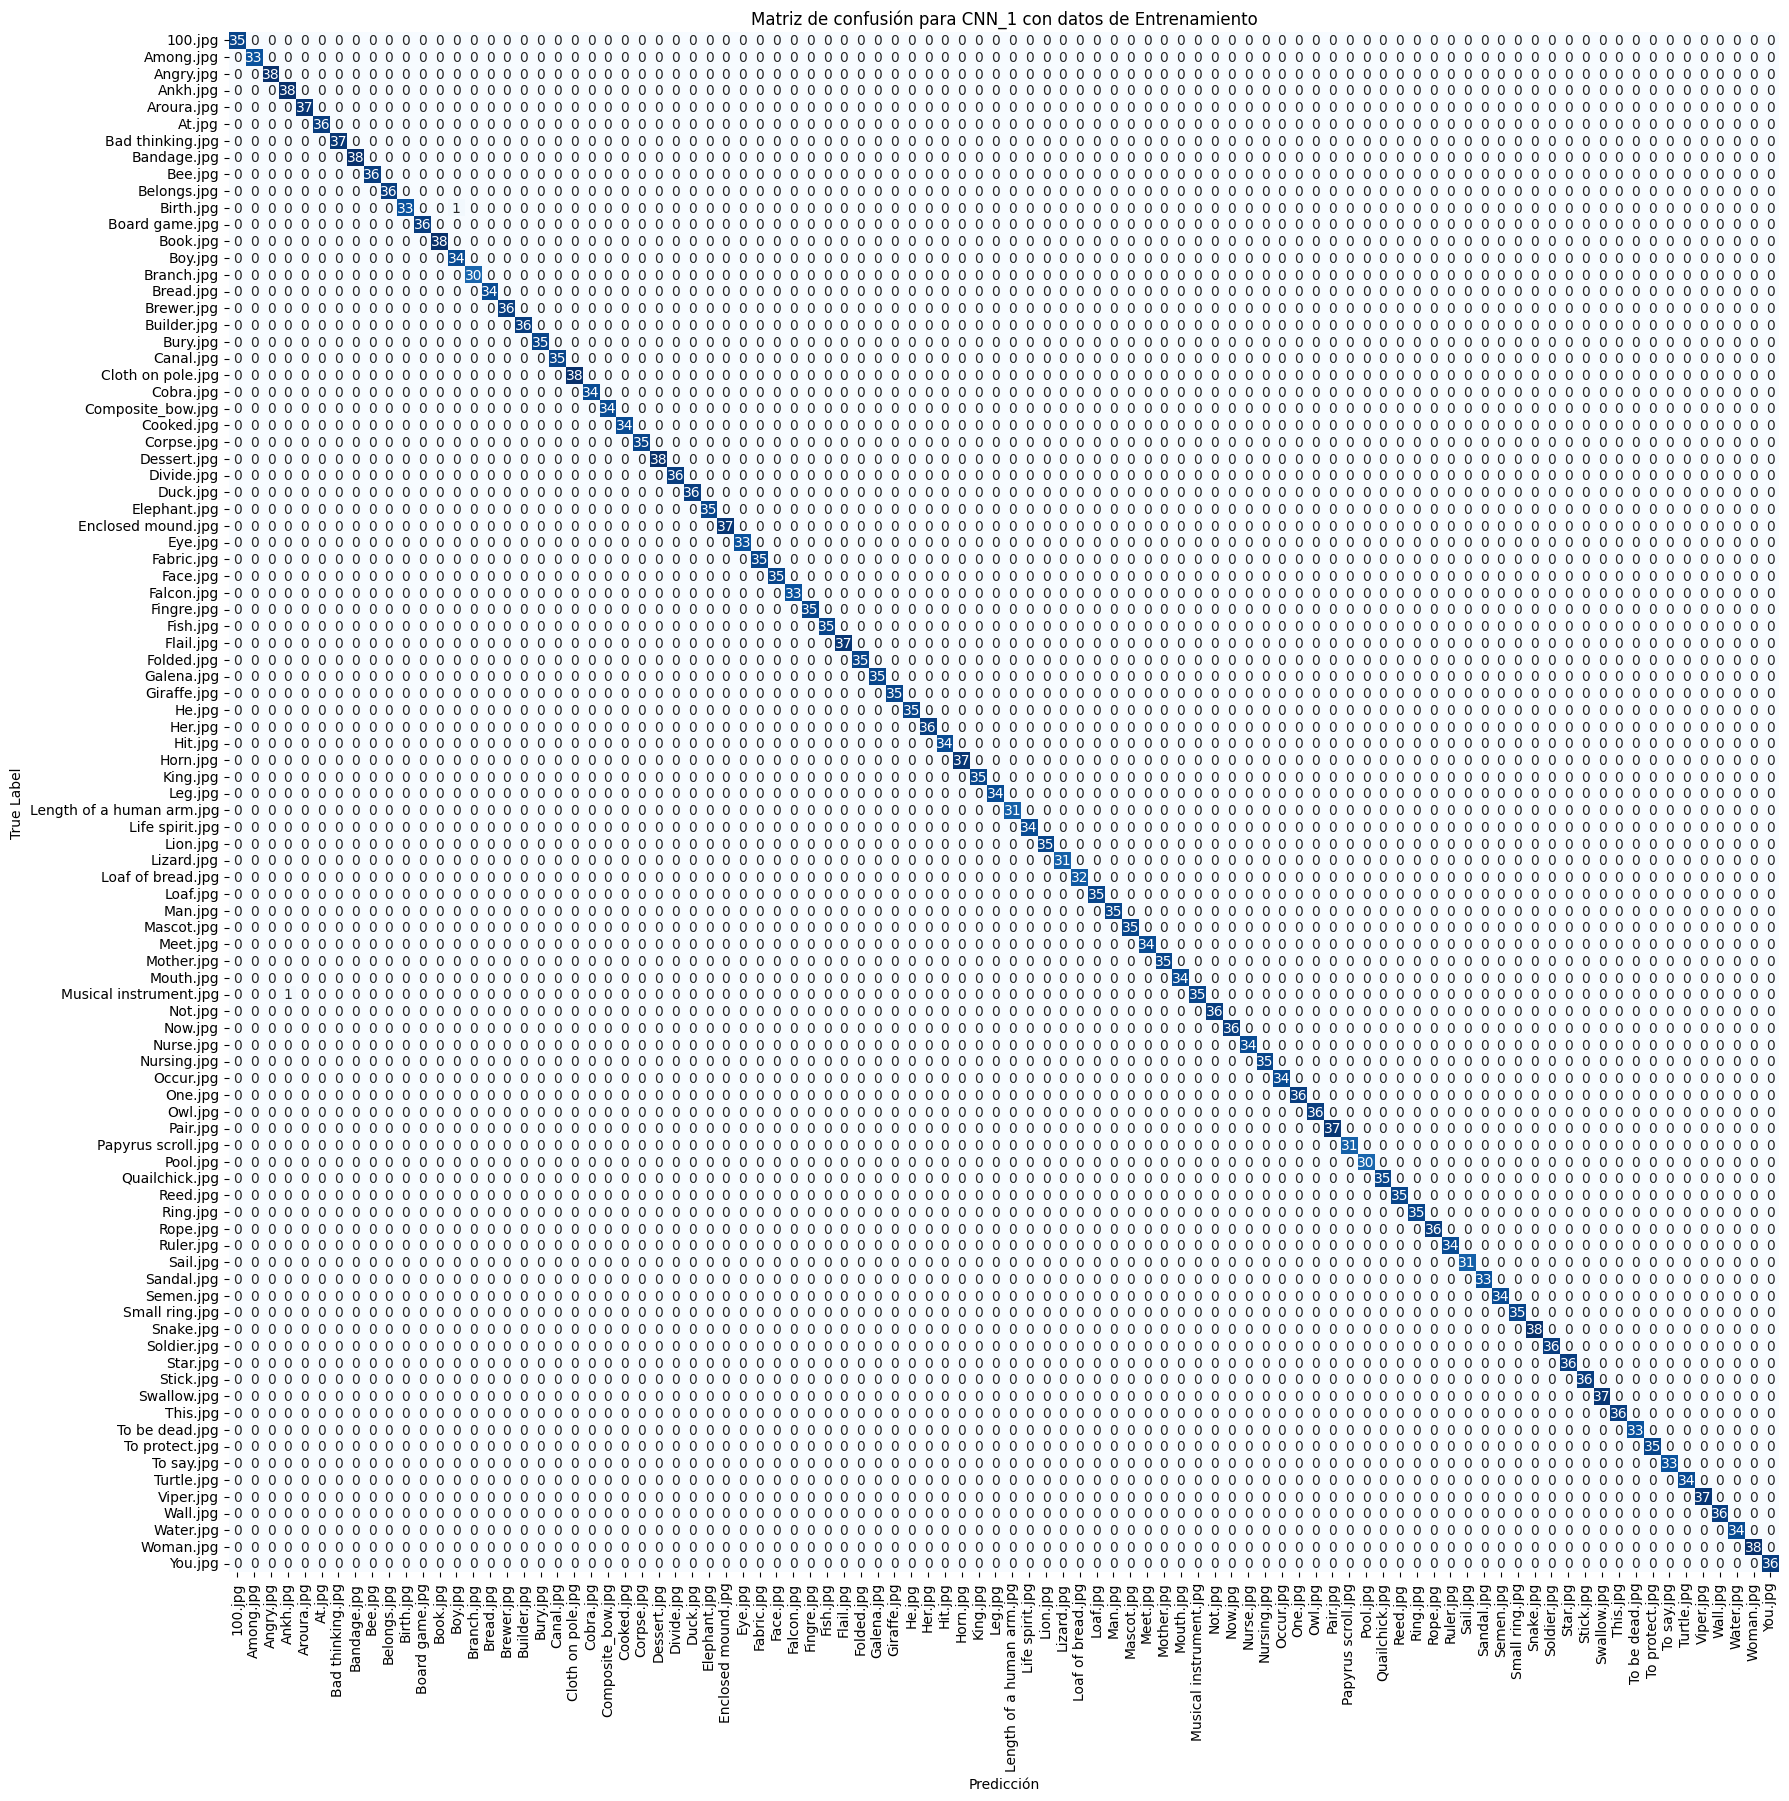

In [28]:
show_model_performance(x_train,y_train,cnn_1, "Entrenamiento",list(training_category_counts.keys()))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       0.92      0.92      0.92        13
                Among.jpg       0.81      1.00      0.90        13
                Angry.jpg       1.00      0.85      0.92        13
                 Ankh.jpg       0.81      1.00      0.90        13
               Aroura.jpg       0.75      0.69      0.72        13
                   At.jpg       0.67      0.92      0.77        13
         Bad thinking.jpg       0.91      0.77      0.83        13
              Bandage.jpg       0.79      0.85      0.81        13
                  Bee.jpg       0.86      0.92      0.89        13
              Belongs.jpg       0.80      0.92      0.86        13
                Birth.jpg       0.92      0.92      0.92        13
           Board game.jpg       1.00      0.92      0.96        13
                 Book.jpg       1.00      0.85      0.92        13
                  Boy.jpg       

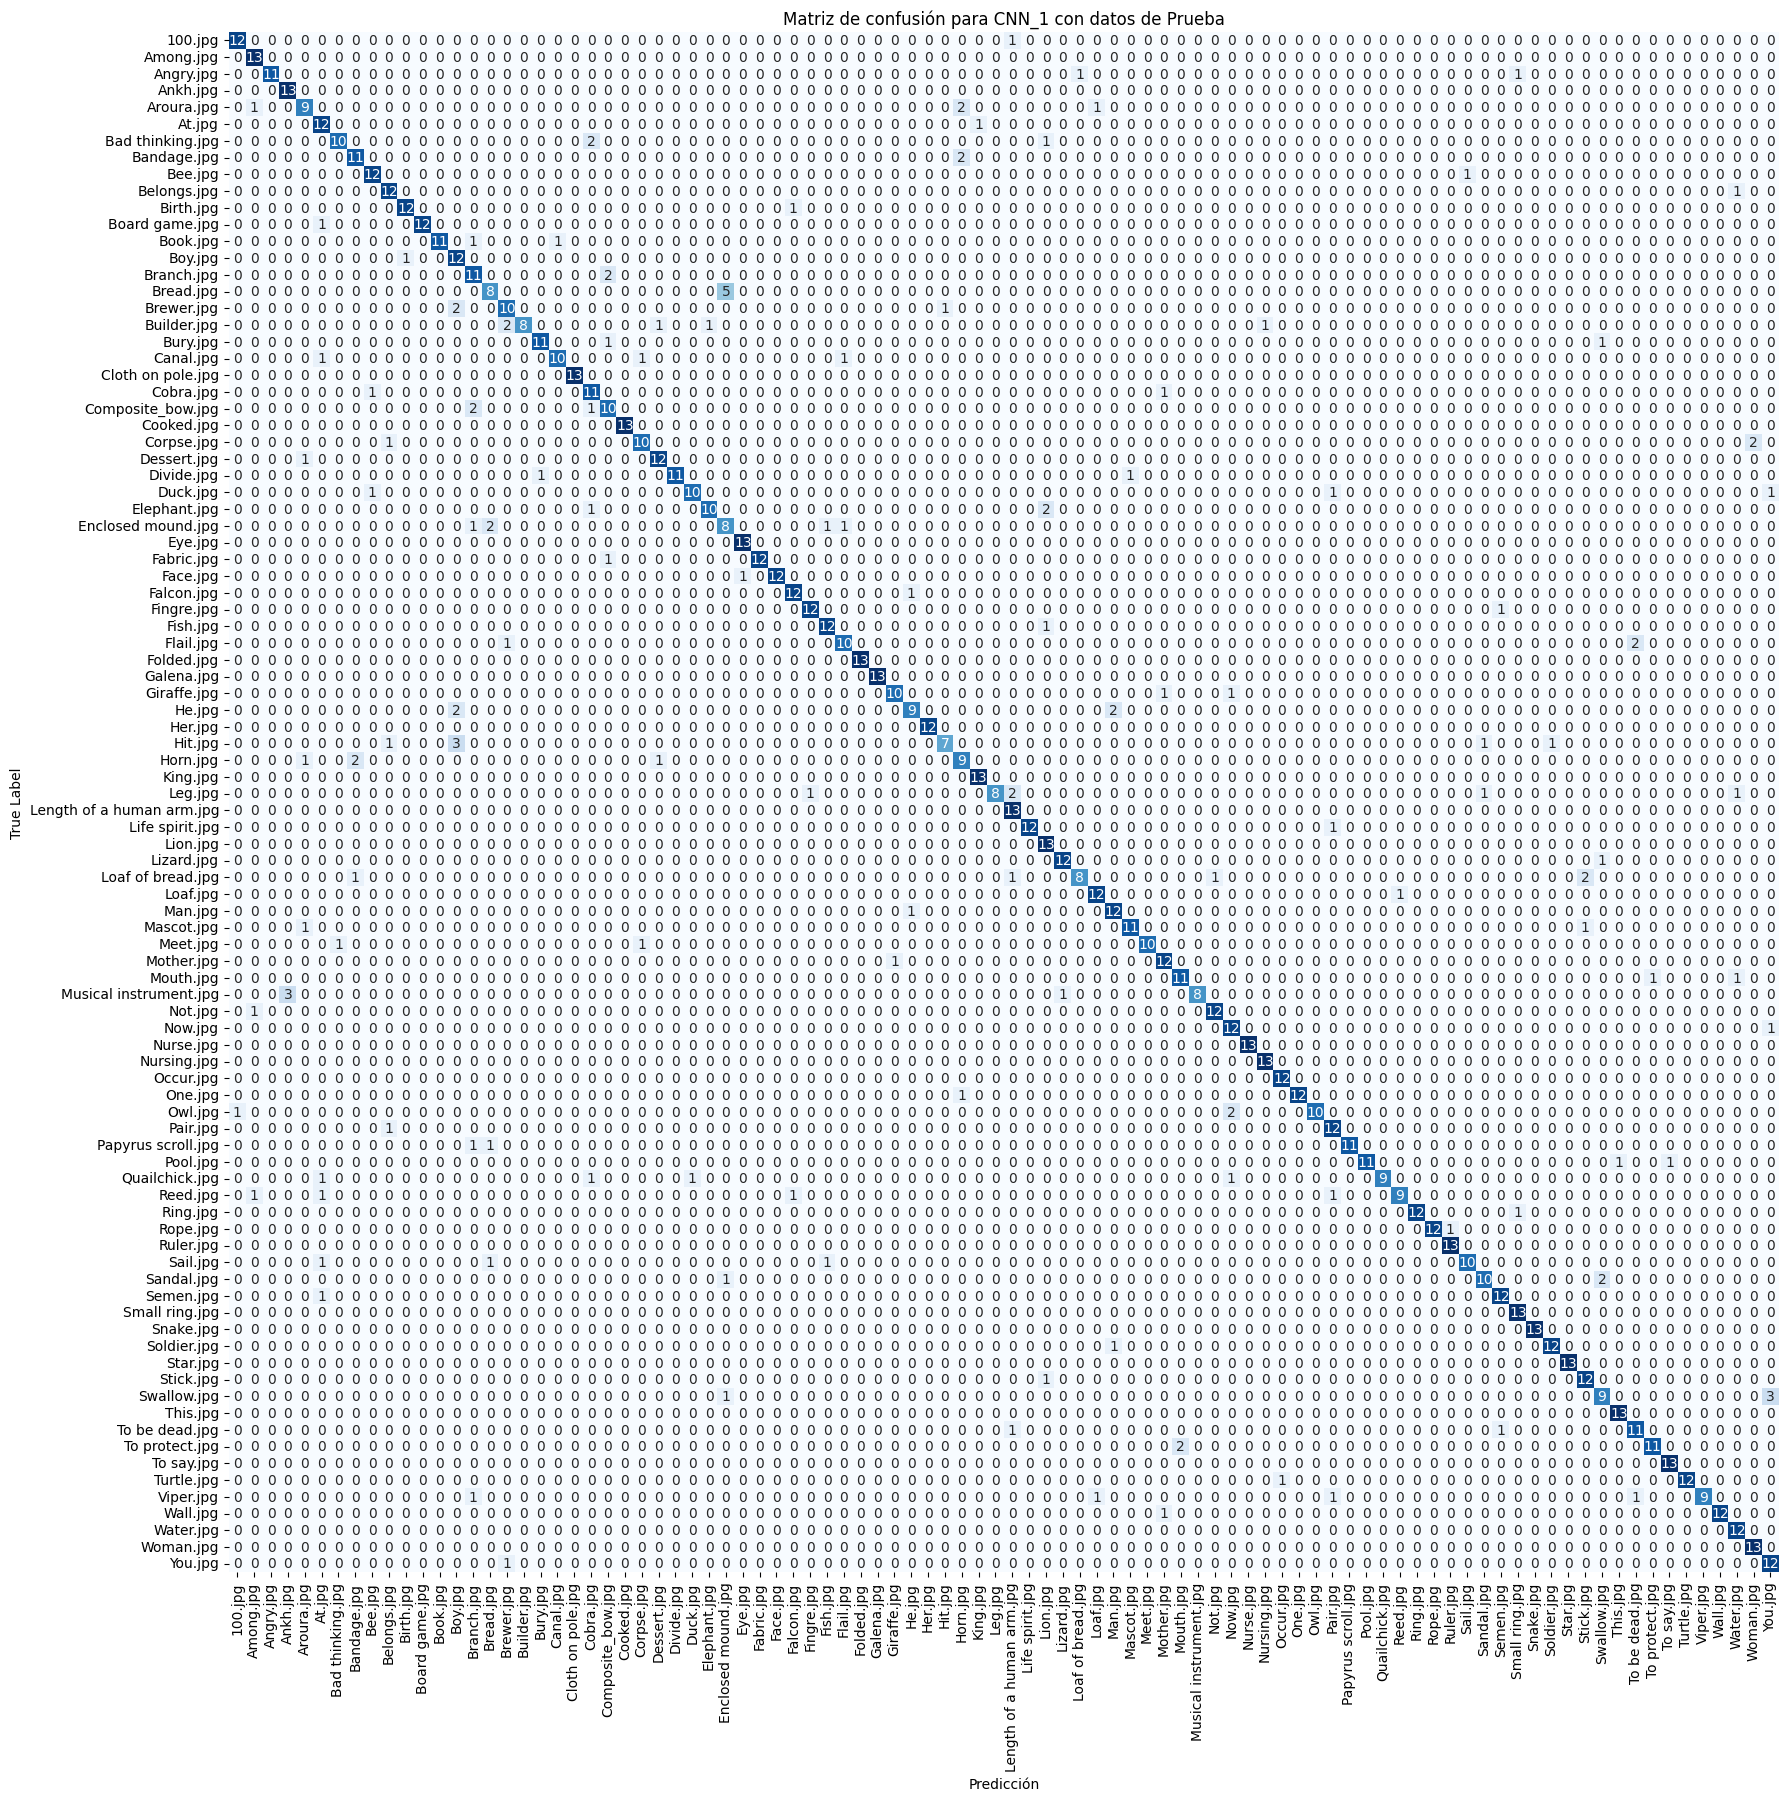

In [29]:
show_model_performance(x_test,y_test,cnn_1, "Prueba",list(training_category_counts.keys()))

#### 5.3.2 Segundo intento
Observando los resultados de la red anterior, podemos ver que la red alcanza valores muy altos de exactitud y bajos de error a médida que avanzan las épocas para los datos de entrenamiento, sin embargo para los datos de validación y de prueba, el rendimiento no es tan bueno. Esto nos nos indica que el modelo está  sufriendo de sobreajuste (overfitting).

Una forma posible de resolver esto es utilizando capas de Dropout que ponen aleatoriamente en 0 los valores de entrada, lo que ayuda a evitar el sobreajuste. Para este segundo intento utilizaremos la misma configuración que en el ejemplo anterior, agregando una capa Dropout con un rate de 0.5

In [30]:
cnn_2_inputs = tf.keras.Input(shape=(128, 128, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(cnn_2_inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
cnn_2_outputs = tf.keras.layers.Dense(category_count, activation="softmax")(x)

cnn_2 = Model(inputs=cnn_2_inputs, outputs=cnn_2_outputs, name = "CNN_2")

In [31]:
cnn_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_2.summary()

Model: "CNN_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 92)             │        11,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,315,932 (12.65 MB)

 Trainable params: 3,315,932 (12.65 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
cnn_2_history = cnn_2.fit(x_train, y_train, epochs=100,
                    validation_data=(x_validation, y_validation),
                    callbacks=[cnn_early_stopping])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - accuracy: 0.0236 - loss: 4.4930 - val_accuracy: 0.2117 - val_loss: 3.6066
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - accuracy: 0.1826 - loss: 3.4953 - val_accuracy: 0.5432 - val_loss: 2.0027
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 381ms/step - accuracy: 0.4335 - loss: 2.1799 - val_accuracy: 0.7326 - val_loss: 1.2658
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 365ms/step - accuracy: 0.6018 - loss: 1.4564 - val_accuracy: 0.8134 - val_loss: 0.8555
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 424ms/step - accuracy: 0.7003 - loss: 0.9986 - val_accuracy: 0.8579 - val_loss: 0.6371
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.7787 - loss: 0.7576 - val_accuracy: 0.8524 - val_loss: 0.6755
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 378ms/step - accuracy: 0.8113 - loss: 0.6365 - val_accuracy: 0.8802 - val_loss: 0.4786
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 382ms/step - accuracy: 0.8355 -

In [33]:
save_model(cnn_2)
cnn_2.evaluate(x_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9389 - loss: 0.2258


[0.24477583169937134, 0.9394958019256592]

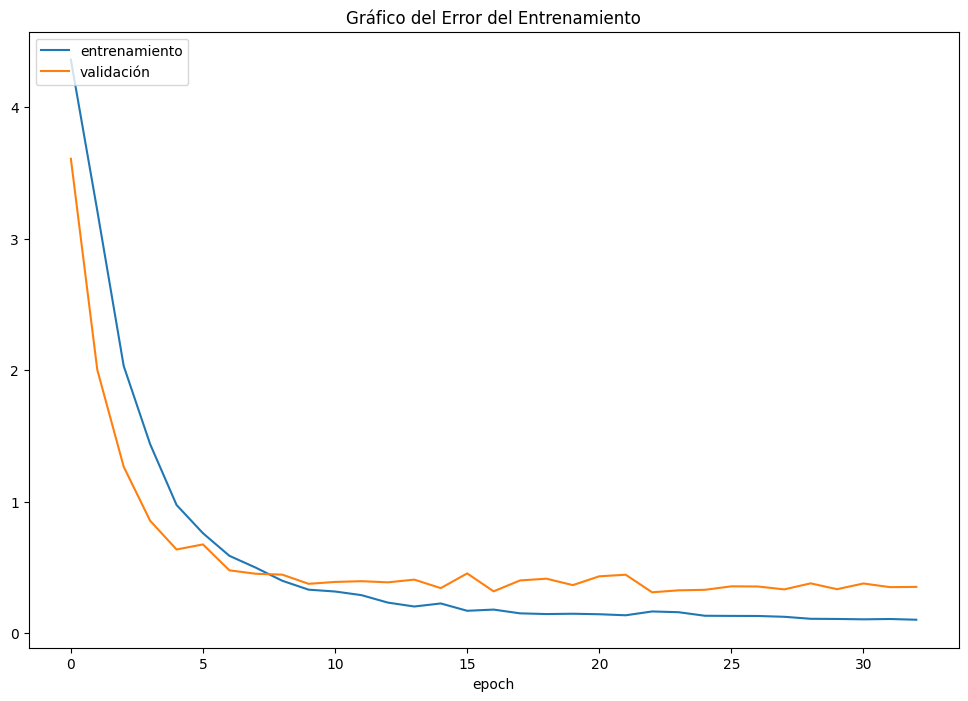

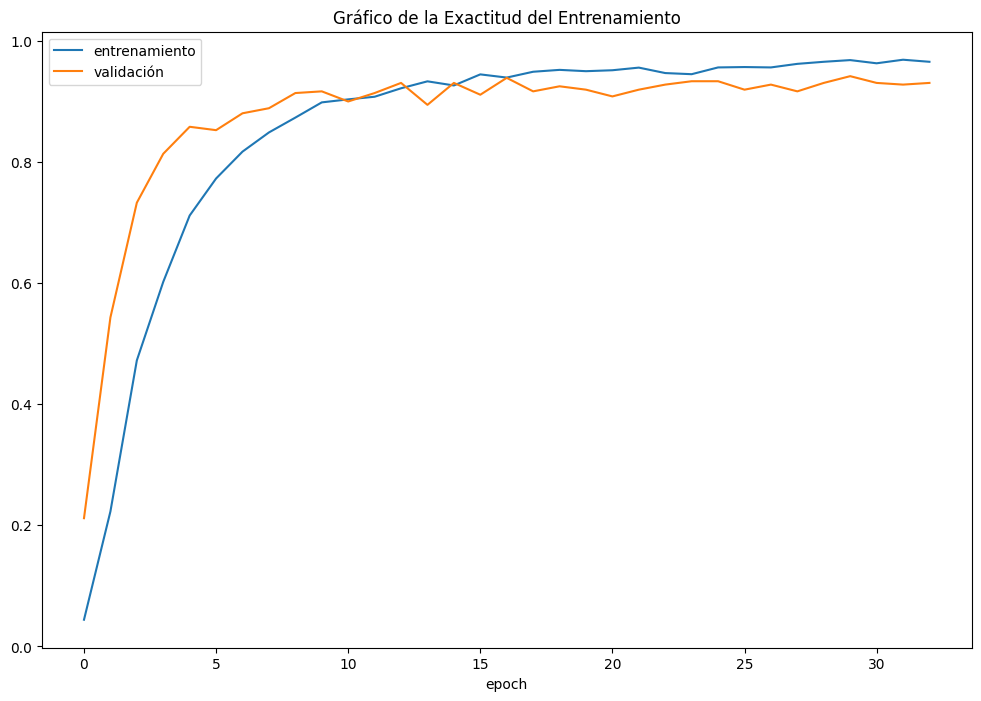

In [34]:
plot_training_history(cnn_2_history, (12,8))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       1.00      1.00      1.00        35
                Among.jpg       1.00      1.00      1.00        33
                Angry.jpg       1.00      1.00      1.00        38
                 Ankh.jpg       1.00      1.00      1.00        38
               Aroura.jpg       1.00      1.00      1.00        37
                   At.jpg       1.00      1.00      1.00        36
         Bad thinking.jpg       1.00      1.00      1.00        37
              Bandage.jpg       1.00      1.00      1.00        38
                  Bee.jpg       1.00      1.00      1.00        36
              Belongs.jpg       1.00      1.00      1.00        36
                Birth.jpg       1.00      1.00      1.00        34
           Board game.jpg       1.00      1.00      1.00        36
                 Book.jpg       1.00      1.00      1.00        38
                  Boy.jpg       

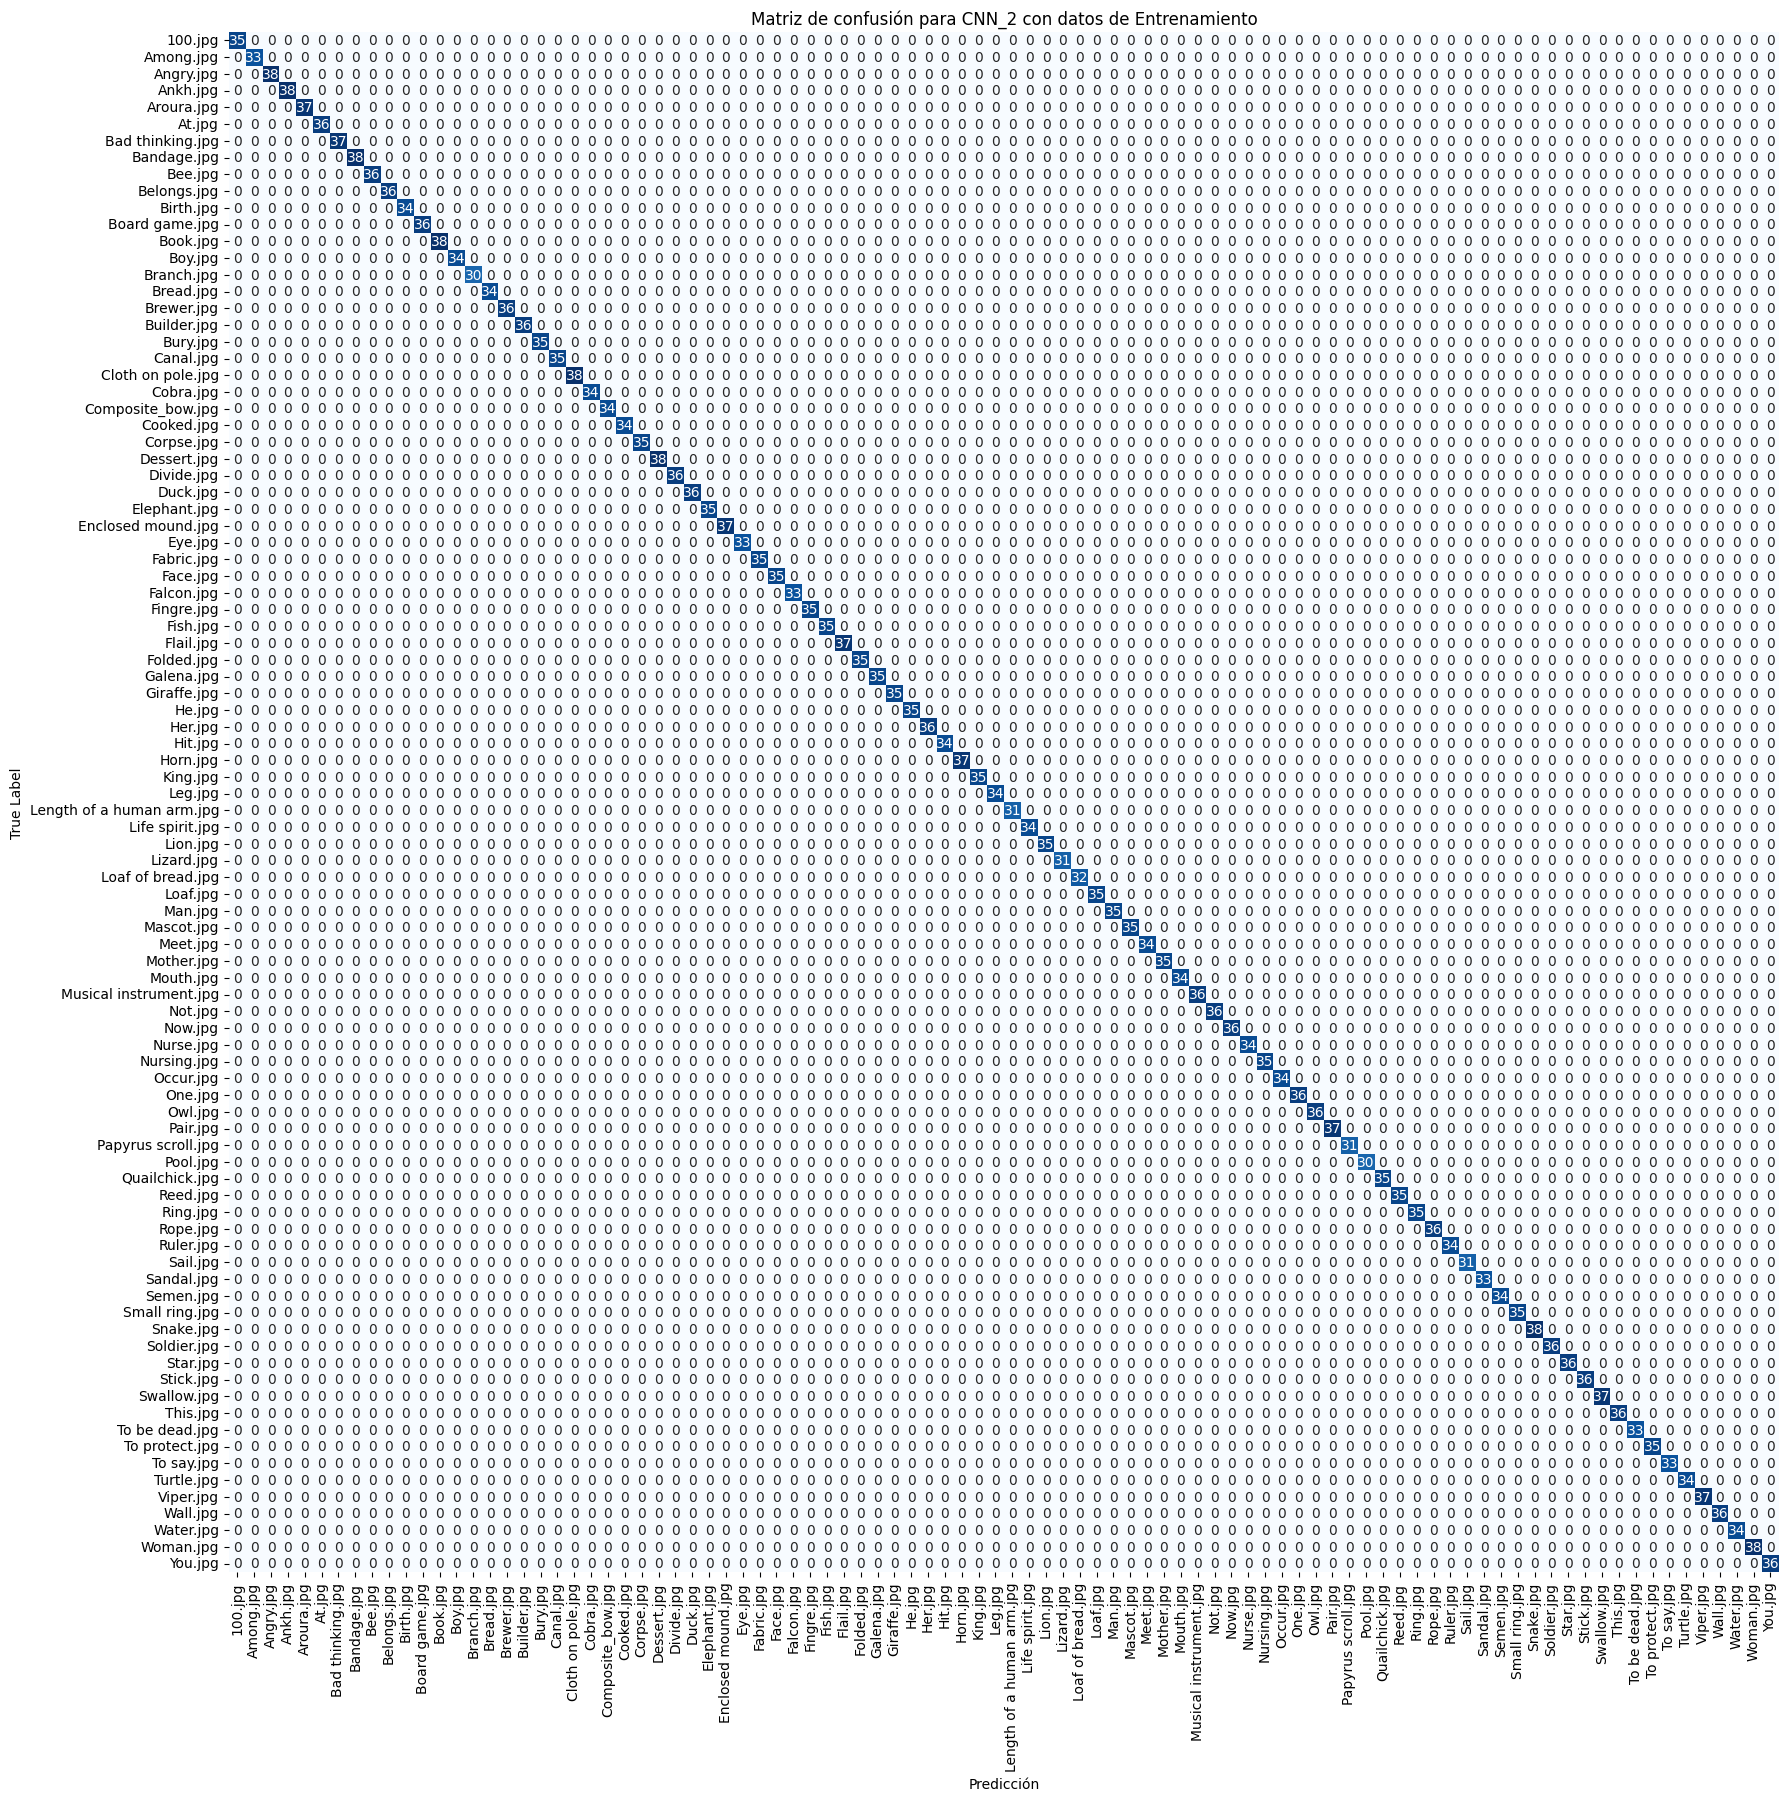

In [35]:
show_model_performance(x_train, y_train, cnn_2, "Entrenamiento", list(training_category_counts.keys()))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       1.00      0.92      0.96        13
                Among.jpg       1.00      1.00      1.00        13
                Angry.jpg       1.00      1.00      1.00        13
                 Ankh.jpg       1.00      1.00      1.00        13
               Aroura.jpg       0.92      0.92      0.92        13
                   At.jpg       1.00      0.92      0.96        13
         Bad thinking.jpg       0.92      0.92      0.92        13
              Bandage.jpg       0.93      1.00      0.96        13
                  Bee.jpg       1.00      1.00      1.00        13
              Belongs.jpg       1.00      1.00      1.00        13
                Birth.jpg       1.00      1.00      1.00        13
           Board game.jpg       1.00      1.00      1.00        13
                 Book.jpg       1.00      0.92      0.96        13
                  Boy.jpg       

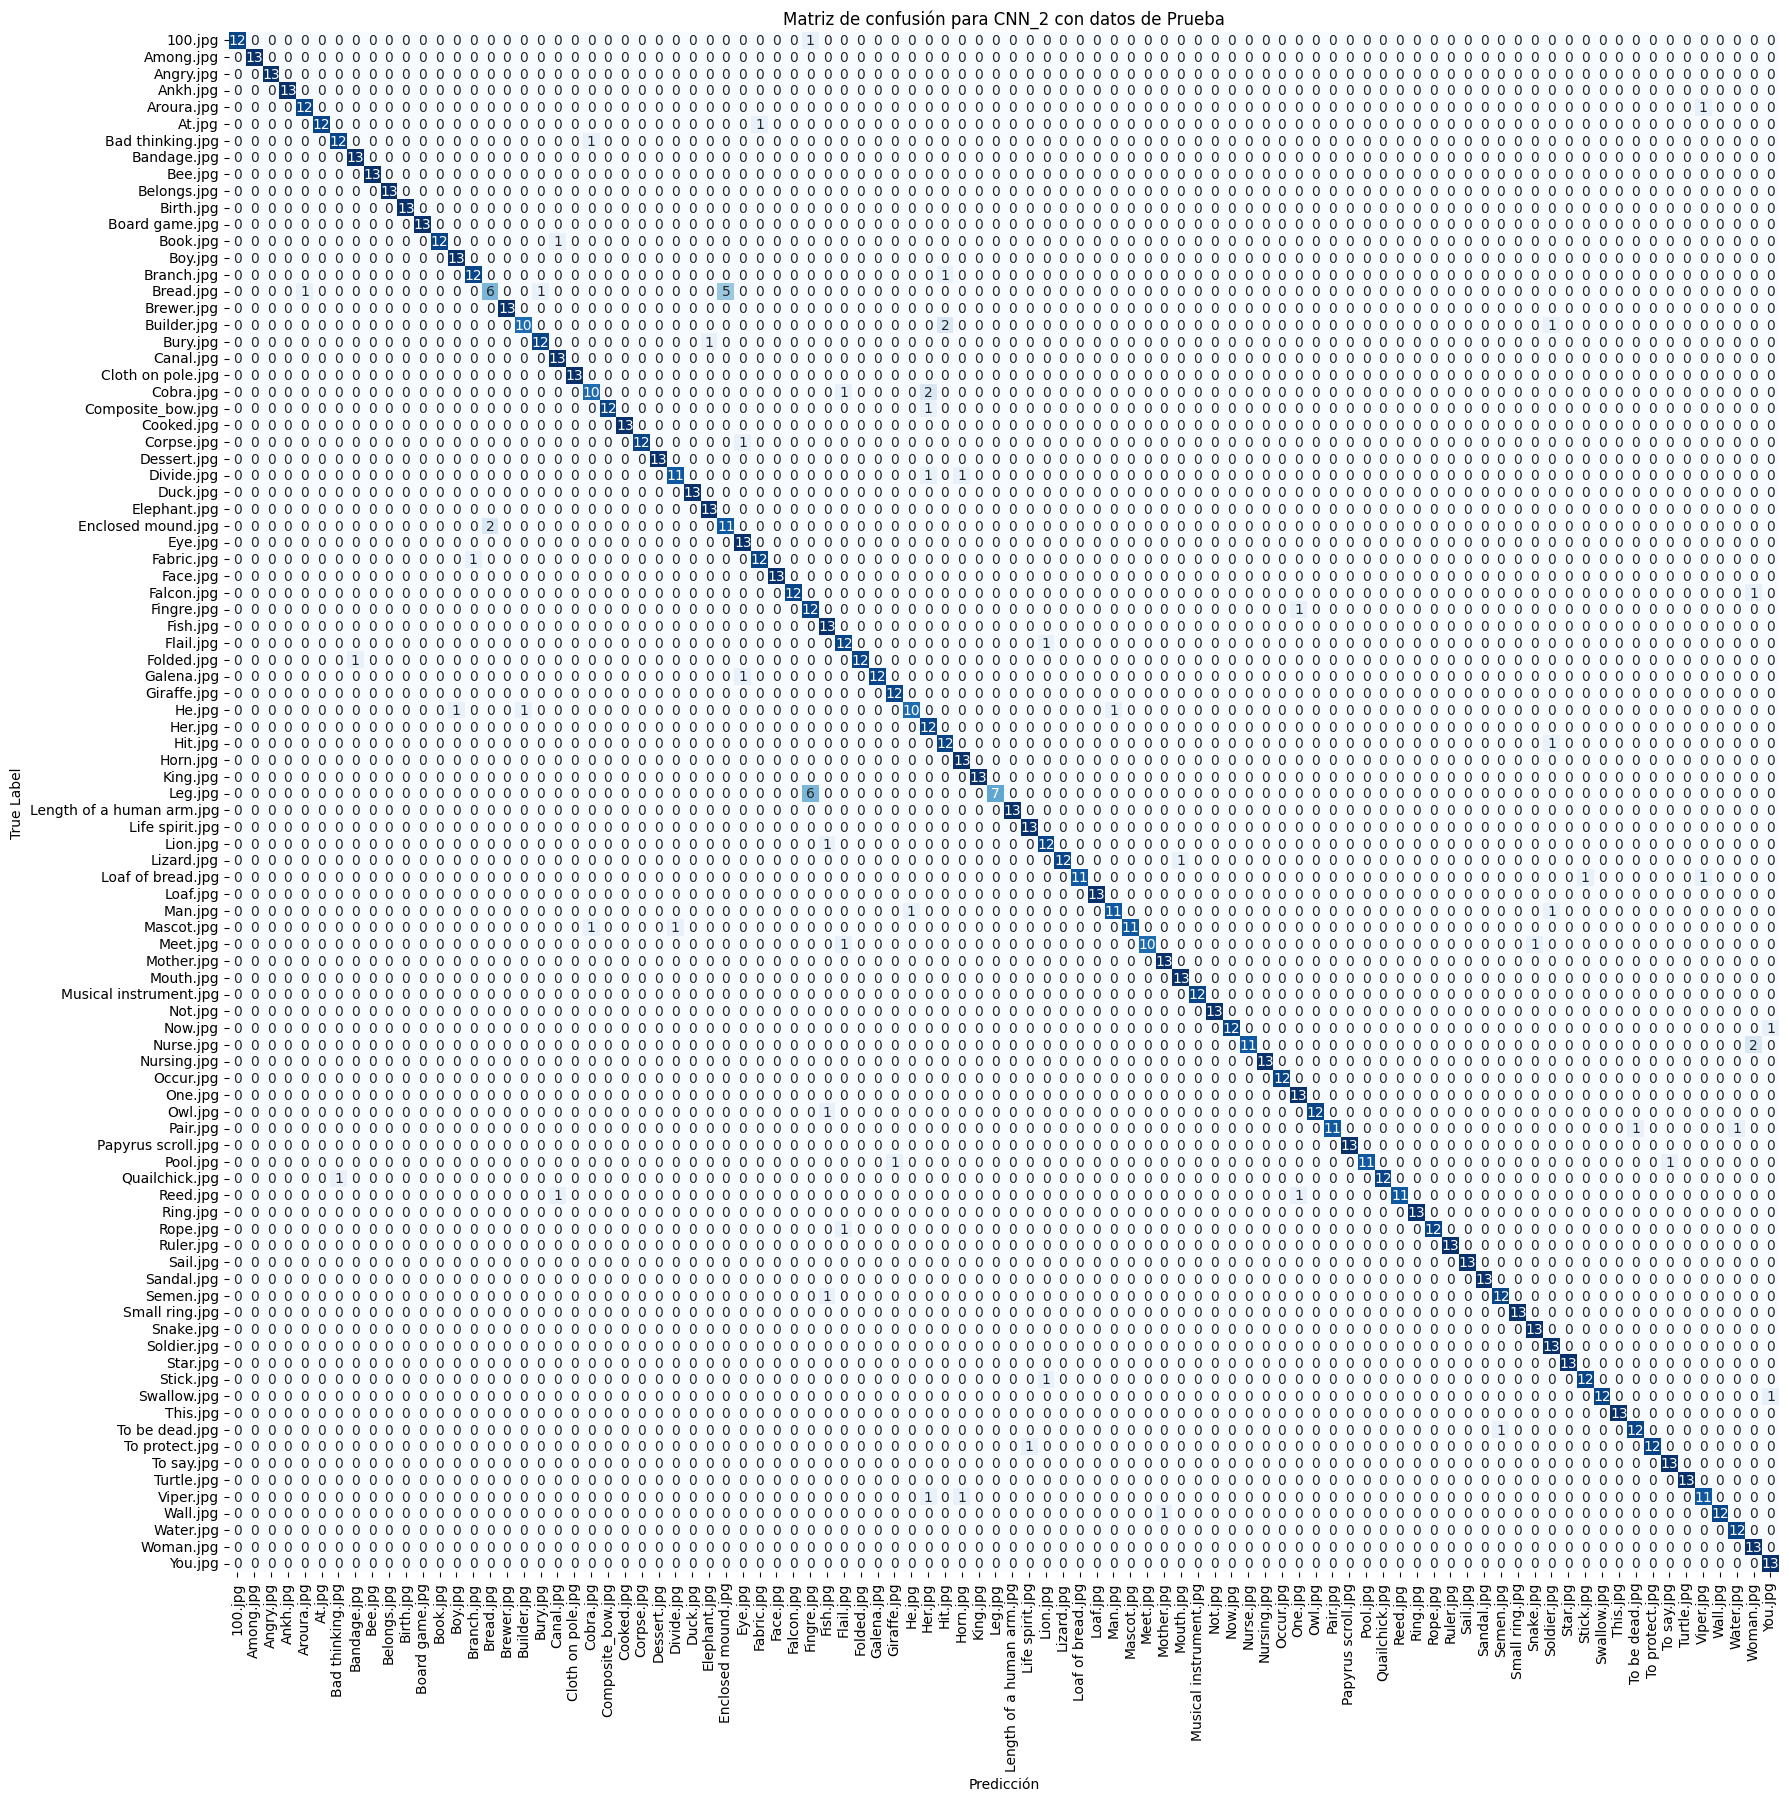

In [36]:
show_model_performance(x_test, y_test, cnn_2, "Prueba", list(training_category_counts.keys()))